<a href="https://colab.research.google.com/github/Vaelastraszz/Movies_Content_based_filtering/blob/master/Projet_3_Mode%CC%81lisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#all libraries import
import sys
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import numpy as np
import seaborn as sns 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn import cluster, metrics
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pickle
import requests

In [0]:
url="/Users/RomainLejeune/Desktop/Data Vizu/Movies_clean.csv"
df = pd.read_csv(url, sep='\t' , encoding = 'utf8')

In [0]:
pd.options.display.max_columns = None
df.head(30)

On va droper toute les features textuelles qui ne pourront pas être prises en compte dans notre modèle de recommandation

In [0]:
col_text=['actor_1_facebook_likes','actor_1_name','actor_2_facebook_likes','actor_2_name',
          'actor_3_facebook_likes','actor_3_name','content_rating','country','director_facebook_likes',
         'director_name','genres','language','movie_title','num_critic_for_reviews','num_user_for_reviews']

In [0]:
dfm = df 

In [0]:
dfm.drop(col_text, axis=1, inplace=True)

Observation de la nouvelle frame sans features textuelles

In [0]:
dfm.head()

,cast_total_facebook_likes,color,duration,imdb_score,num_voted_users,title_year,language_n,country_n,G,NC-17,PG,PG-13,R,TV-14,TV-G,TV-PG,director_name_n,actor_1_n,actor_2_n,actor_3_n,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,critics_ratio
0,4834.0,1.0,178.0,7.9,886204,2009.0,4302.0,3498,0,0,0,1,0,0,0,0,7,7,6,6,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.236739
1,48350.0,1.0,169.0,7.1,471220,2007.0,4302.0,3498,0,0,0,1,0,0,0,0,7,36,11,6,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.243942
2,11700.0,1.0,148.0,6.8,275868,2015.0,4302.0,401,0,0,0,1,0,0,0,0,7,9,4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.605634
3,106759.0,1.0,164.0,8.5,1144337,2012.0,4302.0,3498,0,0,0,1,0,0,0,0,8,12,27,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.301000
4,1873.0,1.0,132.0,6.6,212204,2012.0,4302.0,3498,0,0,0,1,0,0,0,0,3,5,9,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.626016


# Modélisation avec PCA et KNN

On va commencer par faire une PCA pour voir si cela fonctionne bien avec le modèle, on testera avec et sans réduction dimensionelle car notre somme de features n'est pas si élevée (44 en entrée)

In [0]:
dfm['duration']=dfm['duration'].fillna(dfm['duration'].mean())

On va checker que le dataframe est bien rempli a 100%

In [0]:
dfm.isnull().values.any()

False

In [0]:
X = dfm.values

On va normaliser l'ensemble de la matrice afin d'avoir une matrice symétrique et normalisée

In [0]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

On va créer un graphique afin d'étudier le nombre de composantes optimales expliquant une portion suffisammenet élevée de la variance de notre jeu de données

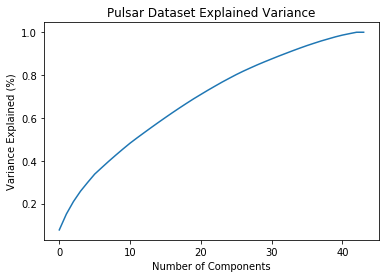

In [0]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

On voit que pour 30 composantes on a un plutot bon rendu avec plus de 80% d'expliquation de la variance

In [0]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=30)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Observation de la variance expliquée

In [0]:
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.sum())

[0.07682377 0.07410266 0.05833328 0.04848298 0.04065256 0.03904351
 0.0303951  0.02999216 0.02884162 0.0280981  0.0272649  0.02495935
 0.02422762 0.02401796 0.02357251 0.02312952 0.02277353 0.02217321
 0.02159336 0.02107763 0.01997434 0.01981881 0.01903863 0.01876746
 0.01767864 0.01736522 0.01612101 0.01502551 0.01473035 0.01384472]
0.8619200056752088


On va récupérer nos projections dans une matrice transformée afin de les réutiliser dans l'algo qu'on choisit :

In [0]:
X_projected = pca.transform(X_scaled)

On va choisir KNN comme algorithme non supervisé et choisir les 6 proches plus voisins afin d'avoir les 5 plus proches films car X[0] de KNN sera le point choisi en entrée car la distance sera nulle 

In [0]:
knn = NearestNeighbors(n_neighbors=16,p=1,metric='manhattan')
knn.fit(X_projected)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='manhattan',
         metric_params=None, n_jobs=1, n_neighbors=16, p=1, radius=1.0)

In [0]:
Liste_voisins = knn.kneighbors(X_projected, return_distance=False)

Création des fonctions permettant d'afficher ensuite la liste des recommandations de films, on fera un tri sur les choix selon la similitude entre les titres afin d'éviter une recommandation de trop de sequel et prequels

In [0]:
def get_reco(id):
    Liste_movies=[]
    for i in range(1,16):        
        Liste_movies.append(Liste_voisins[id,i])
    return Liste_movies   
   

In [0]:
def Affichage(id):
    print ('Recommandation pour le film {} avec KNN: '.format(df["movie_title"].iloc[[id]].item()) )
    Liste_f = get_reco(id)
    counter=0
    
    for i in range(0,15):
        
        if fuzz.partial_ratio(df["movie_title"].iloc[[id]].item(),df["movie_title"].iloc[[Liste_f[i]]].item())<=70:
            
            print('Film {} recommandé: {}'.format(counter+1,df["movie_title"].iloc[[Liste_f[i]]].item()) )
            counter=counter+1
            
            if counter == 5:
                 break
    
    return

Affichage de la liste des recommandations selon l'id du film mis en entrée

In [0]:
Affichage(98)

Recommandation pour le film The Fast and the Furious  avec KNN: 
Film 1 recommandé: The Italian Job 
Film 2 recommandé: Premium Rush 
Film 3 recommandé: Survivor 
Film 4 recommandé: Taken 2 
Film 5 recommandé: Transporter 2 


# Modélisation avec Clustering Hiérarchique de Ward

In [0]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(250, 35))
plt.title("Movies Dendograms") 
dend = shc.dendrogram(shc.linkage(X_projected, method='ward'))  

En tracant une ligne entre les plus grandes distances du dendrogramme on compte a peu près 51 clusters on va tester ca maintenant avec le clustering hiérarchique.

In [0]:
cluster_agg = AgglomerativeClustering(n_clusters=84, affinity='euclidean', linkage='ward')  
Liste_cluster=cluster_agg.fit_predict(X_projected) 

In [0]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

On a créeé une fonction permettant de récupérer le cluster que l'on veut

In [0]:
ClusterIndicesNumpy(12,Liste_cluster)

array([   0,    1,    9,   10,   12,   14,   17,   27,   28,   33,   35,
         36,   38,   39,   43,   45,   47,   51,   52,   59,   61,   64,
         74,   75,   76,   82,   85,  107,  110,  121,  165,  168,  173,
        182,  198,  202,  211,  228,  229,  231,  232,  247,  333,  417,
        424,  473,  480,  481,  504,  508,  584,  998, 1074, 1390, 1479,
       1970, 2877])

In [0]:
def Affichage_Cluster(id):
    print ('Recommandation pour le film {} avec Cluster-Ward:'.format(df["movie_title"].iloc[[id]].item()) )
    
    cluster_id = Liste_cluster[id]
    
    for i in range(0,10):
        
        if ClusterIndicesNumpy(cluster_id,Liste_cluster)[i]!=id :
            
             print('Film {} recommandé: {}'.format(i+1,df["movie_title"].iloc[[ClusterIndicesNumpy(cluster_id,Liste_cluster)[i]]].item()) )
    
    return

In [0]:
Affichage_Cluster(133)

Recommandation pour le film Mission: Impossible - Rogue Nation  avec Cluster-Ward:
Film 1 recommandé: Spectre 
Film 2 recommandé: Quantum of Solace 
Film 3 recommandé: King Kong 
Film 4 recommandé: Skyfall 
Film 5 recommandé: The Legend of Tarzan 
Film 6 recommandé: Poseidon 
Film 7 recommandé: Hancock 
Film 9 recommandé: Mission: Impossible III 
Film 10 recommandé: Mission: Impossible - Ghost Protocol 


In [0]:
df[df.movie_title=="The Fast and the Furious\xa0"]

,actor_1_facebook_likes,actor_1_name,actor_2_facebook_likes,actor_2_name,actor_3_facebook_likes,actor_3_name,cast_total_facebook_likes,color,content_rating,country,director_facebook_likes,director_name,duration,genres,imdb_score,language,movie_title,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year,language_n,country_n,G,NC-17,PG,PG-13,R,TV-14,TV-G,TV-PG,director_name_n,actor_1_n,actor_2_n,actor_3_n,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,critics_ratio
98,23000.0,Paul Walker,14000.0,Vin Diesel,4000.0,Jordana Brewster,45327.0,1.0,PG-13,USA,357.0,Rob Cohen,106.0,Action|Crime|Thriller,6.7,English,The Fast and the Furious,187.0,988.0,272223,2001.0,4302.0,3498,0,0,0,1,0,0,0,0,9,17,17,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.189271


# Modélisation avec Clustering Kmeans

On va choisir le meme nb de cluster que pour le clustering hiérarchique cad 84

In [0]:
cls=cluster.KMeans(n_clusters=84)
Liste_cluster_KM=cls.fit_predict(X_projected)

In [0]:
def Affichage_Cluster_KM(id):
    print ('Recommandation pour le film {} avec KMEANS:'.format(df["movie_title"].iloc[[id]].item()) )
    
    cluster_id = Liste_cluster_KM[id]
    
    for i in range(0,10):
        
        if ClusterIndicesNumpy(cluster_id,Liste_cluster_KM)[i]!=id :
            
             print('Film {} recommandé: {}'.format(i+1,df["movie_title"].iloc[[ClusterIndicesNumpy(cluster_id,Liste_cluster_KM)[i]]].item()) )
    
    return

In [0]:
Affichage_Cluster_KM(133)

Recommandation pour le film Mission: Impossible - Rogue Nation  avec KMEANS:
Film 1 recommandé: Pirates of the Caribbean: At World's End 
Film 2 recommandé: Spectre 
Film 3 recommandé: Quantum of Solace 
Film 4 recommandé: Pirates of the Caribbean: Dead Man's Chest 
Film 5 recommandé: Pirates of the Caribbean: On Stranger Tides 
Film 6 recommandé: Men in Black 3 
Film 7 recommandé: The Hobbit: The Battle of the Five Armies 
Film 8 recommandé: The Amazing Spider-Man 
Film 9 recommandé: The Hobbit: The Desolation of Smaug 
Film 10 recommandé: King Kong 


# Sérialisation d'un modèle en pkl et test server

Sauvegarde du modèle de KNN sur le disque dur

In [0]:
pickle.dump(knn, open('/Users/RomainLejeune/Downloads/concevez_un_site_avec_flask-P1C1/Projet 3/model.pkl','wb'))
pickle.dump(X_projected, open('/Users/RomainLejeune/Downloads/concevez_un_site_avec_flask-P1C1/Projet 3/X_json.pkl','wb'))
pickle.dump(df, open('/Users/RomainLejeune/Downloads/concevez_un_site_avec_flask-P1C1/Projet 3/df.pkl','wb'))

Loading du modèle directement du disque

In [0]:
#url = 'http://127.0.0.1:5000/api'
url = 'http://romz2.pythonanywhere.com/api'

r = requests.post(url,json={'id':1,})

print(r.json())

['[20]: The Amazing Spider-Man', '[106]: Warcraft', '[205]: Clash of the Titans', '[313]: The Mummy Returns', '[832]: The Forbidden Kingdom']


# Phase de test des modèles sur plusieurs types de films

In [0]:
Affichage(113)
print("")
Affichage_Cluster(113)
print("")
Affichage_Cluster_KM(113)

Recommandation pour le film Harry Potter and the Goblet of Fire  avec KNN: 
Film 1 recommandé: The Imaginarium of Doctor Parnassus 
Film 2 recommandé: Harry Potter and the Half-Blood Prince 
Film 3 recommandé: Triangle 
Film 4 recommandé: The Hobbit: The Battle of the Five Armies 
Film 5 recommandé: Winter's Tale 

Recommandation pour le film Harry Potter and the Goblet of Fire  avec Cluster-Ward:
Film 1 recommandé: Harry Potter and the Half-Blood Prince 
Film 2 recommandé: The Chronicles of Narnia: Prince Caspian 
Film 3 recommandé: Alice in Wonderland 
Film 4 recommandé: Oz the Great and Powerful 
Film 5 recommandé: A Christmas Carol 
Film 6 recommandé: The Chronicles of Narnia: The Lion, the Witch and the Wardrobe 
Film 7 recommandé: Hugo 
Film 8 recommandé: Evan Almighty 
Film 9 recommandé: Maleficent 
Film 10 recommandé: Alice Through the Looking Glass 

Recommandation pour le film Harry Potter and the Goblet of Fire  avec KMEANS:
Film 1 recommandé: The Chronicles of Narnia: Princ